In [2]:
import torch

In [3]:
# Load the CLN025 dataset
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# Load the CLN025 dataset
dataset_path = "/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/CLN025-0-cad.pt"
print(f"Loading dataset from: {dataset_path}")

# Load the dataset
dataset = torch.load(dataset_path, map_location="cpu")
print(f"Dataset type: {type(dataset)}")
print(f"Dataset keys: {dataset.keys() if isinstance(dataset, dict) else 'Not a dict'}")

# Examine the structure
if isinstance(dataset, dict):
    for key, value in dataset.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: shape={value.shape}, dtype={value.dtype}")
        else:
            print(f"{key}: type={type(value)}")
elif isinstance(dataset, torch.Tensor):
    print(f"Dataset shape: {dataset.shape}, dtype: {dataset.dtype}")
else:
    print(f"Dataset structure: {type(dataset)}")


Loading dataset from: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/CLN025-0-cad.pt
Dataset type: <class 'torch.Tensor'>
Dataset keys: Not a dict
Dataset shape: torch.Size([534743, 45]), dtype: torch.float32


In [4]:
# Find and list all available jit models for CLN025
model_dir = Path("/home/shpark/prj-mlcv/lib/bioemu/opes/model")
baseline_dir = model_dir / "_baseline_"

# Find all CLN025 jit models
cln025_jit_models = []

# Check baseline models
if baseline_dir.exists():
    baseline_models = list(baseline_dir.glob("*CLN025-jit.pt"))
    cln025_jit_models.extend(baseline_models)
    print("Baseline models:")
    for model in baseline_models:
        print(f"  {model.name}")

# Check your models  
your_models = list(model_dir.glob("*CLN025*jit.pt"))
your_models = [m for m in your_models if m.parent == model_dir]  # exclude baseline dir
cln025_jit_models.extend(your_models)

print("\nYour models:")
for model in your_models:
    print(f"  {model.name}")

print(f"\nTotal CLN025 jit models found: {len(cln025_jit_models)}")
for model in cln025_jit_models:
    print(f"  {model}")


Baseline models:
  tica-CLN025-jit.pt
  tda-CLN025-jit.pt
  vde-CLN025-jit.pt
  tae-CLN025-jit.pt

Your models:
  0816_171833-CLN025-jit.pt
  0816_171833-CLN025-f32-jit.pt

Total CLN025 jit models found: 6
  /home/shpark/prj-mlcv/lib/bioemu/opes/model/_baseline_/tica-CLN025-jit.pt
  /home/shpark/prj-mlcv/lib/bioemu/opes/model/_baseline_/tda-CLN025-jit.pt
  /home/shpark/prj-mlcv/lib/bioemu/opes/model/_baseline_/vde-CLN025-jit.pt
  /home/shpark/prj-mlcv/lib/bioemu/opes/model/_baseline_/tae-CLN025-jit.pt
  /home/shpark/prj-mlcv/lib/bioemu/opes/model/0816_171833-CLN025-jit.pt
  /home/shpark/prj-mlcv/lib/bioemu/opes/model/0816_171833-CLN025-f32-jit.pt


In [5]:
# Load all models and compute outputs
model_outputs = {}
model_info = {}

# Prepare input data - check what format the models expect
print("Dataset structure analysis:")
if isinstance(dataset, dict):
    # Try common keys that might contain the coordinate data
    input_data = None
    for key in ['pos', 'positions', 'coords', 'coordinates', 'cad']:
        if key in dataset:
            input_data = dataset[key]
            print(f"Using '{key}' as input data: shape={input_data.shape}")
            break
    
    if input_data is None:
        # Use the first tensor we find
        for key, value in dataset.items():
            if isinstance(value, torch.Tensor):
                input_data = value
                print(f"Using '{key}' as input data: shape={input_data.shape}")
                break
elif isinstance(dataset, torch.Tensor):
    input_data = dataset
    print(f"Using dataset directly: shape={input_data.shape}")

print(f"\nInput data shape: {input_data.shape}")
print(f"Input data dtype: {input_data.dtype}")
print(f"Input data range: [{input_data.min():.4f}, {input_data.max():.4f}]")

# Take a subset for faster testing (first 1000 frames if available)
if len(input_data) > 1000:
    input_subset = input_data[:1000]
    print(f"Using subset for testing: {input_subset.shape}")
else:
    input_subset = input_data
    print(f"Using full dataset: {input_subset.shape}")


Dataset structure analysis:
Using dataset directly: shape=torch.Size([534743, 45])

Input data shape: torch.Size([534743, 45])
Input data dtype: torch.float32
Input data range: [0.3508, 3.0170]
Using subset for testing: torch.Size([1000, 45])


In [10]:
# Import additional dependencies for compute_cv_values
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def compute_cv_values(
    mlcv_model,
    cad_torch,
    model_type,
    reference_cad=None,
    batch_size=10000,
):
    """Compute CV values from the model with optional sign flipping using batch processing."""
    dataset = TensorDataset(cad_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    print(f"Computing CV values in batches of {batch_size}...")
    
    with torch.no_grad():
        sample_batch = next(iter(dataloader))[0]
        sample_output = mlcv_model(sample_batch)
        output_dim = sample_output.shape[1]
    cv_batches = torch.zeros((len(cad_torch), output_dim)).to(cad_torch.device)
    
    with torch.no_grad():
        for batch_idx, (batch_data,) in enumerate(tqdm(
            dataloader,
            desc="Computing CV values",
            total=len(dataloader),
            leave=False,
        )):
            batch_cv = mlcv_model(batch_data)
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_cv.shape[0]  # Handle last batch size correctly
            cv_batches[start_idx:end_idx] = batch_cv
    
    cv = cv_batches.detach().cpu().numpy()
    MLCV_DIM = cv.shape[1]
    
    print(f"CV computation complete. Shape: {cv.shape}")
    
    if model_type == "mlcv":
        # Normalize CV values for MLCV
        cv_normalized = np.zeros_like(cv)
        
        for cv_dim in range(MLCV_DIM):
            cv_dim_val = cv[:, cv_dim]
            cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
            cv_range_mean = (cv_range_min + cv_range_max) / 2.0
            cv_range = (cv_range_max - cv_range_min) / 2.0
            cv_normalized[:, cv_dim] = (cv_dim_val - cv_range_mean) / cv_range
        
        cv = cv_normalized
        
    # Additional sign flipping based on reference structure
    if reference_cad is not None:
        with torch.no_grad():
            ref_cv = mlcv_model(torch.from_numpy(reference_cad).to(cad_torch.device))
            ref_cv = ref_cv.detach().cpu().numpy()
        
        # Normalize reference CV the same way
        if model_type == "mlcv":
            ref_cv_normalized = np.zeros_like(ref_cv)
            for cv_dim in range(MLCV_DIM):
                ref_cv_dim_val = ref_cv[:, cv_dim]
                cv_dim_val = cv[:, cv_dim]
                cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
                cv_range_mean = (cv_range_min + cv_range_max) / 2.0
                cv_range = (cv_range_max - cv_range_min) / 2.0
                ref_cv_normalized[:, cv_dim] = (ref_cv_dim_val - cv_range_mean) / cv_range
            ref_cv = ref_cv_normalized
        
        # Flip signs to ensure reference CV is positive
        for cv_dim in range(MLCV_DIM):
            if ref_cv[0, cv_dim] < 0:
                cv[:, cv_dim] = -cv[:, cv_dim]
                print(f"Flipped sign for CV dimension {cv_dim} to ensure positive reference value")
    
    return cv

print("✓ compute_cv_values function defined")


✓ compute_cv_values function defined


In [14]:
# Load all models and compute CV values using compute_cv_values function
model_cv_outputs = {}
model_info = {}

print("Loading models and computing CV values...")
print("=" * 60)

for model_path in cln025_jit_models:
    model_name = model_path.name.replace('.pt', '').replace('-jit', '')
    print(f"\nProcessing: {model_name}")
    
    try:
        # Load the model
        model = torch.jit.load(str(model_path), map_location="cpu")
        model.eval()
        print(f"  ✓ Model loaded successfully")
        
        # Determine model type based on name
        if 'mlcv' in model_name.lower() or '0816' in model_name:
            model_type = "mlcv"  # Your models
        else:
            model_type = "baseline"  # Baseline models (tae, tda, tica, vde)
        
        print(f"  ✓ Model type: {model_type}")
        
        # Compute CV values using the proper function
        try:
            cv_values = compute_cv_values(
                mlcv_model=model,
                cad_torch=input_data,  # Use full dataset for CV computation
                model_type=model_type,
                reference_cad=None,
                batch_size=10000  # Smaller batch size for memory efficiency
            )
            
            print(f"  ✓ CV values computed successfully")
            print(f"  ✓ CV shape: {cv_values.shape}")
            print(f"  ✓ CV range: [{cv_values.min():.4f}, {cv_values.max():.4f}]")
            
            # Check if in [-1, 1] range
            in_range = np.all((cv_values >= -1.01) & (cv_values <= 1.01))
            print(f"  ✓ In [-1, 1] range: {in_range}")
            
            # Store results
            model_cv_outputs[model_name] = cv_values
            model_info[model_name] = {
                'shape': cv_values.shape,
                'min': cv_values.min(),
                'max': cv_values.max(),
                'in_range': in_range,
                'model_type': model_type,
                'path': str(model_path)
            }
            
        except Exception as e:
            print(f"  ✗ CV computation failed: {e}")
            model_info[model_name] = {
                'error': f'CV computation failed: {e}',
                'model_type': model_type,
                'path': str(model_path)
            }
            
    except Exception as e:
        print(f"  ✗ Failed to load model: {e}")
        model_info[model_name] = {
            'error': f'Failed to load: {e}',
            'path': str(model_path)
        }

print(f"\n\nSUMMARY:")
print("=" * 60)
for name, info in model_info.items():
    if 'error' in info:
        print(f"{name}: ERROR - {info['error']}")
    else:
        range_status = "✓ IN RANGE" if info['in_range'] else "✗ OUT OF RANGE"
        print(f"{name} ({info['model_type']}): [{info['min']:.4f}, {info['max']:.4f}] - {range_status}")


Loading models and computing CV values...

Processing: tica-CLN025
  ✓ Model loaded successfully
  ✓ Model type: baseline
Computing CV values in batches of 5000...


CV computation complete. Shape: (534743, 1)
  ✓ CV values computed successfully
  ✓ CV shape: (534743, 1)
  ✓ CV range: [-1.0000, 1.0000]
  ✓ In [-1, 1] range: True

Processing: tda-CLN025
  ✓ Model loaded successfully
  ✓ Model type: baseline
Computing CV values in batches of 5000...


CV computation complete. Shape: (534743, 1)
  ✓ CV values computed successfully
  ✓ CV shape: (534743, 1)
  ✓ CV range: [-1.0000, 1.0000]
  ✓ In [-1, 1] range: True

Processing: vde-CLN025
  ✓ Model loaded successfully
  ✓ Model type: baseline
Computing CV values in batches of 5000...


CV computation complete. Shape: (534743, 1)
  ✓ CV values computed successfully
  ✓ CV shape: (534743, 1)
  ✓ CV range: [-1.0000, 1.0000]
  ✓ In [-1, 1] range: True

Processing: tae-CLN025
  ✓ Model loaded successfully
  ✓ Model type: baseline
Computing CV values in batches of 5000...


CV computation complete. Shape: (534743, 1)
  ✓ CV values computed successfully
  ✓ CV shape: (534743, 1)
  ✓ CV range: [-1.0006, 1.0000]
  ✓ In [-1, 1] range: True

Processing: 0816_171833-CLN025
  ✓ Model loaded successfully
  ✓ Model type: mlcv
Computing CV values in batches of 5000...


CV computation complete. Shape: (534743, 1)
  ✓ CV values computed successfully
  ✓ CV shape: (534743, 1)
  ✓ CV range: [-1.0000, 1.0000]
  ✓ In [-1, 1] range: True

Processing: 0816_171833-CLN025-f32
  ✓ Model loaded successfully
  ✓ Model type: mlcv
Computing CV values in batches of 5000...


CV computation complete. Shape: (534743, 1)
  ✓ CV values computed successfully
  ✓ CV shape: (534743, 1)
  ✓ CV range: [-1.0000, 1.0000]
  ✓ In [-1, 1] range: True


SUMMARY:
tica-CLN025 (baseline): [-1.0000, 1.0000] - ✓ IN RANGE
tda-CLN025 (baseline): [-1.0000, 1.0000] - ✓ IN RANGE
vde-CLN025 (baseline): [-1.0000, 1.0000] - ✓ IN RANGE
tae-CLN025 (baseline): [-1.0006, 1.0000] - ✓ IN RANGE
0816_171833-CLN025 (mlcv): [-1.0000, 1.0000] - ✓ IN RANGE
0816_171833-CLN025-f32 (mlcv): [-1.0000, 1.0000] - ✓ IN RANGE


Creating histograms for 6 successful models...


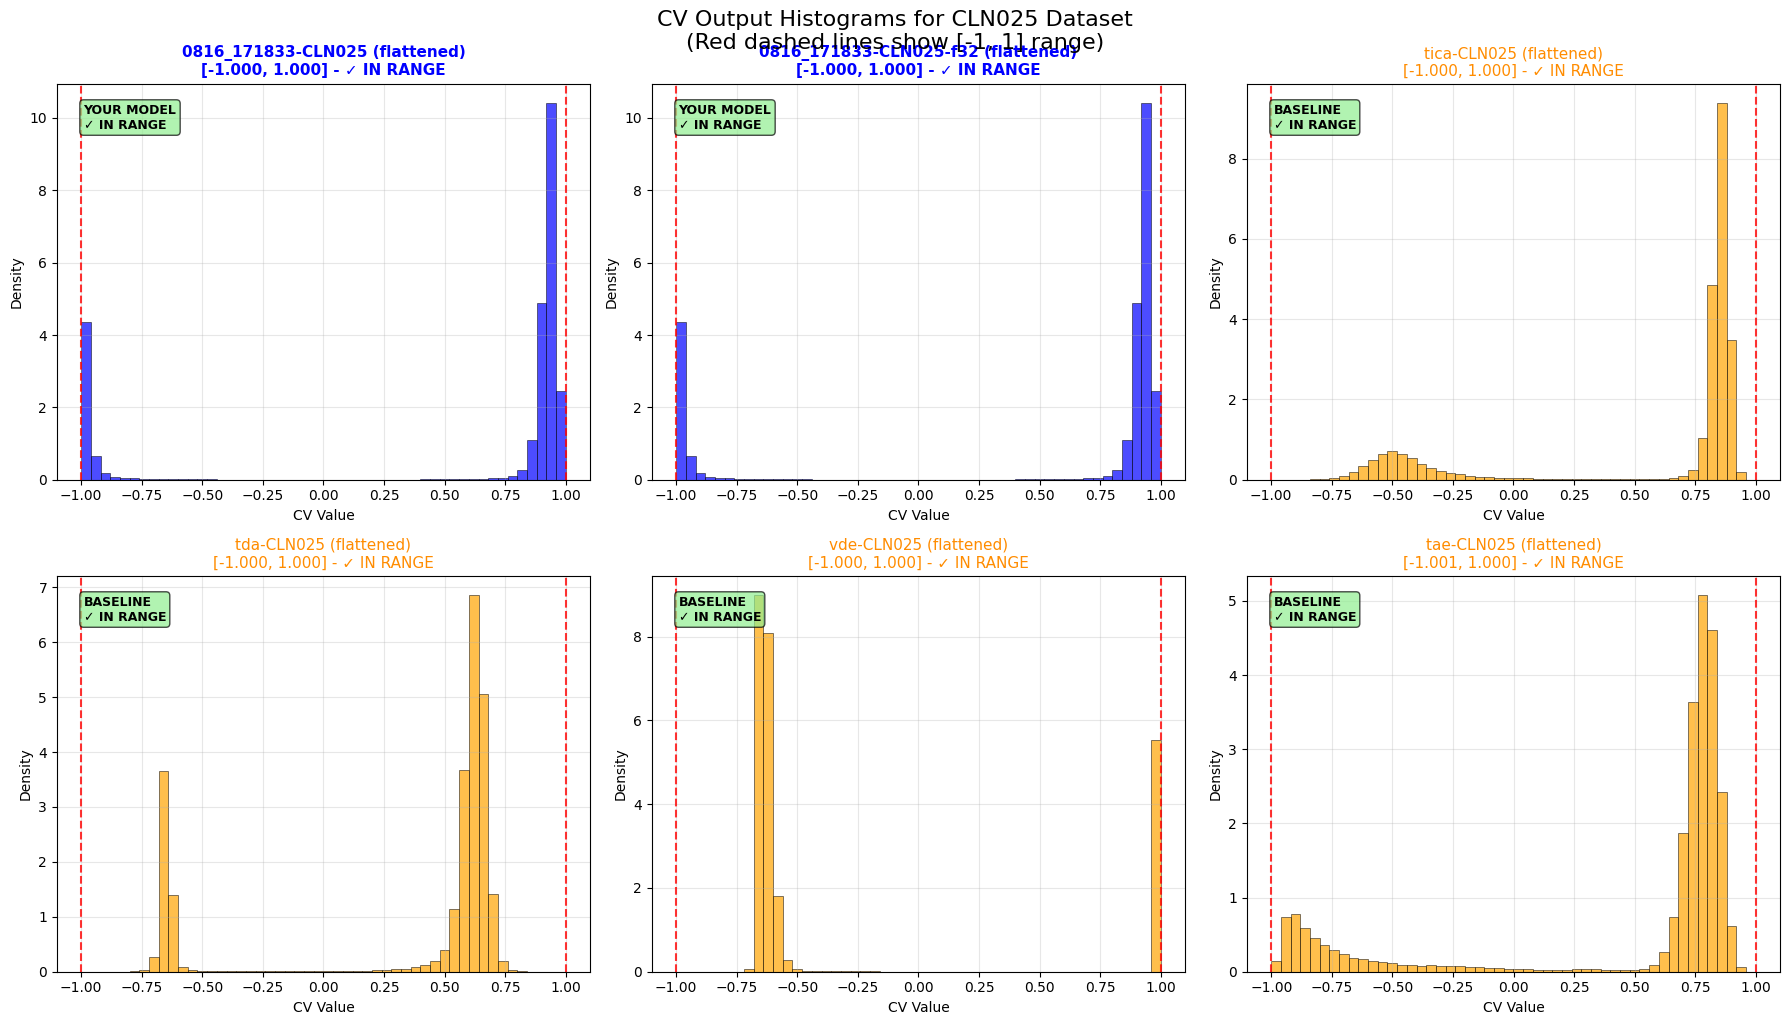


DETAILED CV ANALYSIS SUMMARY
Model Name                     Type       Shape           Min      Max      In Range  
------------------------------------------------------------------------------------------
YOUR MODELS:
  0816_171833-CLN025           mlcv       (534743, 1)     -1.000   1.000    ✓ YES     
  0816_171833-CLN025-f32       mlcv       (534743, 1)     -1.000   1.000    ✓ YES     

BASELINE MODELS:
  tica-CLN025                  baseline   (534743, 1)     -1.000   1.000    ✓ YES     
  tda-CLN025                   baseline   (534743, 1)     -1.000   1.000    ✓ YES     
  vde-CLN025                   baseline   (534743, 1)     -1.000   1.000    ✓ YES     
  tae-CLN025                   baseline   (534743, 1)     -1.001   1.000    ✓ YES     

RANGE COMPLIANCE SUMMARY:
  Models in [-1, 1] range: 6/6
  Compliance rate: 100.0%

✓ COMPLIANT MODELS:
  • tica-CLN025 (baseline)
  • tda-CLN025 (baseline)
  • vde-CLN025 (baseline)
  • tae-CLN025 (baseline)
  • 0816_171833-CLN025 (mlcv)

In [15]:
# Create comprehensive histograms for all successful models
successful_models = {name: cv_vals for name, cv_vals in model_cv_outputs.items() if cv_vals is not None}

if len(successful_models) == 0:
    print("No models produced successful CV outputs. Please check the models and input data format.")
else:
    print(f"Creating histograms for {len(successful_models)} successful models...")
    
    # Separate your models from baselines
    your_models = {name: cv_vals for name, cv_vals in successful_models.items() 
                   if model_info[name]['model_type'] == 'mlcv'}
    baseline_models = {name: cv_vals for name, cv_vals in successful_models.items() 
                      if model_info[name]['model_type'] == 'baseline'}
    
    # Create figure with subplots
    n_models = len(successful_models)
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_models == 1:
        axes = [axes]
    elif n_rows == 1 and n_cols > 1:
        axes = list(axes)
    elif n_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot histograms for each model
    plot_idx = 0
    
    # Plot your models first
    for model_name, cv_values in your_models.items():
        ax = axes[plot_idx]
        
        # Handle multi-dimensional CV outputs
        if cv_values.ndim > 1 and cv_values.shape[1] > 1:
            # Multi-dimensional CV - plot each dimension
            for dim in range(cv_values.shape[1]):
                cv_dim = cv_values[:, dim]
                ax.hist(cv_dim, bins=50, alpha=0.6, density=True, 
                       label=f'CV dim {dim}', edgecolor='black', linewidth=0.5)
            ax.legend()
            title_suffix = f"({cv_values.shape[1]}D CV)"
        else:
            # Single dimension or flatten all dimensions
            cv_flat = cv_values.flatten()
            ax.hist(cv_flat, bins=50, alpha=0.7, density=True, 
                   color='blue', edgecolor='black', linewidth=0.5)
            title_suffix = "(flattened)" if cv_values.ndim > 1 else "(1D CV)"
        
        # Add range boundary lines
        ax.axvline(-1, color='red', linestyle='--', alpha=0.8, label='[-1, 1] bounds')
        ax.axvline(1, color='red', linestyle='--', alpha=0.8)
        
        # Formatting
        info = model_info[model_name]
        range_status = "✓ IN RANGE" if info['in_range'] else "✗ OUT OF RANGE"
        ax.set_title(f"{model_name} {title_suffix}\n[{info['min']:.3f}, {info['max']:.3f}] - {range_status}", 
                    fontsize=11, color='blue', fontweight='bold')
        ax.set_xlabel('CV Value')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        
        # Add range status box
        range_color = "lightgreen" if info['in_range'] else "lightcoral"
        ax.text(0.05, 0.95, f"YOUR MODEL\n{range_status}", 
               transform=ax.transAxes, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor=range_color, alpha=0.7),
               verticalalignment='top', fontweight='bold', fontsize=9)
        
        plot_idx += 1
    
    # Plot baseline models
    for model_name, cv_values in baseline_models.items():
        ax = axes[plot_idx]
        
        # Handle multi-dimensional CV outputs
        if cv_values.ndim > 1 and cv_values.shape[1] > 1:
            # Multi-dimensional CV - plot each dimension
            for dim in range(cv_values.shape[1]):
                cv_dim = cv_values[:, dim]
                ax.hist(cv_dim, bins=50, alpha=0.6, density=True, 
                       label=f'CV dim {dim}', edgecolor='black', linewidth=0.5)
            ax.legend()
            title_suffix = f"({cv_values.shape[1]}D CV)"
        else:
            # Single dimension or flatten all dimensions
            cv_flat = cv_values.flatten()
            ax.hist(cv_flat, bins=50, alpha=0.7, density=True, 
                   color='orange', edgecolor='black', linewidth=0.5)
            title_suffix = "(flattened)" if cv_values.ndim > 1 else "(1D CV)"
        
        # Add range boundary lines
        ax.axvline(-1, color='red', linestyle='--', alpha=0.8, label='[-1, 1] bounds')
        ax.axvline(1, color='red', linestyle='--', alpha=0.8)
        
        # Formatting
        info = model_info[model_name]
        range_status = "✓ IN RANGE" if info['in_range'] else "✗ OUT OF RANGE"
        ax.set_title(f"{model_name} {title_suffix}\n[{info['min']:.3f}, {info['max']:.3f}] - {range_status}", 
                    fontsize=11, color='darkorange')
        ax.set_xlabel('CV Value')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        
        # Add baseline status box
        range_color = "lightgreen" if info['in_range'] else "lightcoral"
        ax.text(0.05, 0.95, f"BASELINE\n{range_status}", 
               transform=ax.transAxes, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor=range_color, alpha=0.7),
               verticalalignment='top', fontweight='bold', fontsize=9)
        
        plot_idx += 1
    
    # Hide unused subplots
    for idx in range(plot_idx, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('CV Output Histograms for CLN025 Dataset\n(Red dashed lines show [-1, 1] range)', 
                 fontsize=16, y=1.02)
    plt.show()
    
    # Print detailed summary
    print("\n" + "="*90)
    print("DETAILED CV ANALYSIS SUMMARY")
    print("="*90)
    print(f"{'Model Name':<30} {'Type':<10} {'Shape':<15} {'Min':<8} {'Max':<8} {'In Range':<10}")
    print("-"*90)
    
    # Show your models first
    print("YOUR MODELS:")
    for name, info in model_info.items():
        if 'error' not in info and info['model_type'] == 'mlcv':
            range_check = "✓ YES" if info['in_range'] else "✗ NO"
            print(f"  {name:<28} {info['model_type']:<10} {str(info['shape']):<15} {info['min']:<8.3f} {info['max']:<8.3f} {range_check:<10}")
    
    print("\nBASELINE MODELS:")
    for name, info in model_info.items():
        if 'error' not in info and info['model_type'] == 'baseline':
            range_check = "✓ YES" if info['in_range'] else "✗ NO"
            print(f"  {name:<28} {info['model_type']:<10} {str(info['shape']):<15} {info['min']:<8.3f} {info['max']:<8.3f} {range_check:<10}")
    
    # Summary statistics
    in_range_count = sum(1 for info in model_info.values() if 'error' not in info and info['in_range'])
    total_count = sum(1 for info in model_info.values() if 'error' not in info)
    
    print(f"\nRANGE COMPLIANCE SUMMARY:")
    print(f"  Models in [-1, 1] range: {in_range_count}/{total_count}")
    print(f"  Compliance rate: {in_range_count/total_count*100:.1f}%")
    
    # Show which models are compliant
    compliant_models = [name for name, info in model_info.items() 
                       if 'error' not in info and info['in_range']]
    non_compliant_models = [name for name, info in model_info.items() 
                           if 'error' not in info and not info['in_range']]
    
    if compliant_models:
        print(f"\n✓ COMPLIANT MODELS:")
        for model in compliant_models:
            model_type = model_info[model]['model_type']
            print(f"  • {model} ({model_type})")
    
    if non_compliant_models:
        print(f"\n✗ NON-COMPLIANT MODELS:")
        for model in non_compliant_models:
            model_type = model_info[model]['model_type']
            print(f"  • {model} ({model_type})")
